In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import random
data = np.load('mnist.npz')
data.files

['x_test', 'x_train', 'y_train', 'y_test']

In [2]:
x_train=data['x_train']
x_test=data['x_test']
y_train=data['y_train']
y_test=data['y_test']

In [4]:
def transform_by_rotation(image,ang):
    return imutils.rotate(image,angle=ang)  

In [24]:
def accuracy(hist):
    return 100*(len(hist[hist["difference"]<=15])/len(hist["difference"]))

In [54]:
li=[0,1,2,3,4,5,6,7,8,9]
info=pd.DataFrame(li,columns=["Number"])
info["Samples available"]=[len(y_train[y_train==i]) for i in li]

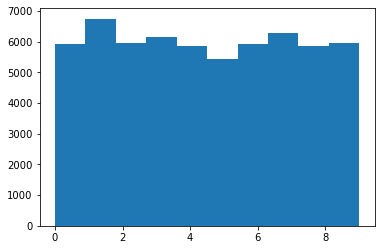

In [58]:
plt.hist(li,weights=info["Samples available"]) ## No of Images Avaiable for each Number
plt.show()

### Transforming the Image by Rotating through some random angle

In [6]:
angle_train=[random.randrange(-45,45,1) for i in range(x_train.shape[0])]
angle_test=[random.randrange(-45,45,1) for i in range(x_test.shape[0])]
transformed_images=[]
transformed_images_test=[]

for i in range(len(angle_train)):
    transformed_images.append(transform_by_rotation(x_train[i,:,:],angle_train[i]))
rx_train=np.array(transformed_images)    


for i in range(len(angle_test)):
    transformed_images_test.append(transform_by_rotation(x_test[i,:,:],angle_test[i]))
rx_test=np.array(transformed_images_test)


### Distribution of transformed angles

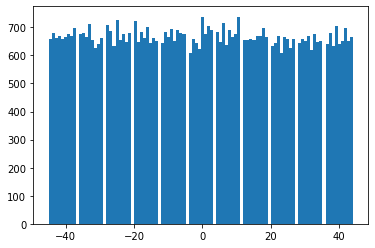

In [7]:
plt.hist(angle_train, bins=100) ## For Training Data
plt.show()

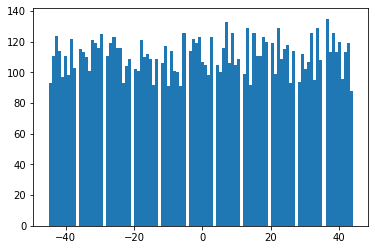

In [8]:
plt.hist(angle_test, bins=100) ## For Test Data
plt.show()

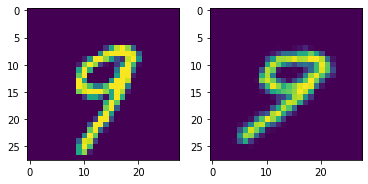

angle rotated by -21


In [9]:
s=57
arr,axi=plt.subplots(1,2)
axi[0].imshow(x_train[s,:,:]/255)
axi[1].imshow(rx_train[s,:,:]/255)
plt.show()
print("angle rotated by " + str(angle_train[s]))

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(8, (3,3), activation='relu',padding="same", input_shape=(28, 28,1)),
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="valid",autocast=False),
  tf.keras.layers.Conv2D(16, (3,3),padding="same", activation='relu'),
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="valid",autocast=False),
  tf.keras.layers.Conv2D(32, (3,3),padding="same", activation='relu'),
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="valid",autocast=False),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0

In [11]:
m=x_train.shape[0]
test_x=rx_test.reshape(rx_test.shape[0],28,28,1)
m2=rx_test.shape[0]
hist1=model.fit(rx_train[:m,:,:].reshape(m,28,28,1), np.array(angle_train[0:m]),batch_size=32, epochs=30,
               validation_data=(rx_test[:m2,:,:].reshape(m2,28,28,1), np.array(angle_train[0:m2])))


Epoch 1/30
1875/1875 [==============================] - 9s 5ms/step - loss: 226.8802 - mae: 11.6925 - val_loss: 1161.4344 - val_mae: 27.9475
Epoch 2/30
1875/1875 [==============================] - 9s 5ms/step - loss: 172.6086 - mae: 10.0654 - val_loss: 1221.4301 - val_mae: 28.5876
Epoch 3/30
1875/1875 [==============================] - 9s 5ms/step - loss: 157.0209 - mae: 9.5406 - val_loss: 1214.1884 - val_mae: 28.5269
Epoch 4/30
1875/1875 [==============================] - 9s 5ms/step - loss: 146.4982 - mae: 9.1891 - val_loss: 1314.1729 - val_mae: 29.6042
Epoch 5/30
1875/1875 [==============================] - 9s 5ms/step - loss: 139.0463 - mae: 8.9058 - val_loss: 1181.6053 - val_mae: 28.1607
Epoch 6/30
1875/1875 [==============================] - 10s 5ms/step - loss: 131.9261 - mae: 8.6268 - val_loss: 1203.3654 - val_mae: 28.4003
Epoch 7/30
1875/1875 [==============================] - 9s 5ms/step - loss: 123.7721 - mae: 8.3360 - val_loss: 1166.1309 - val_mae: 27.9783
Epoch 8/30
1875/1

In [12]:
model.evaluate(rx_test[:m2,:,:].reshape(m2,28,28,1), np.array(angle_train[0:m2]))

313/313 [==============================] - 1s 3ms/step - loss: 1199.2317 - mae: 28.3314


[1199.231689453125, 28.331405639648438]

### Accuracy Of the Model on Training and Test Data

In [15]:
def model_perf(x,y,preds,correct):    
    mae_error=preds-np.array(correct).reshape(x.shape[0],1) 
    hist=pd.DataFrame(mae_error,columns=['error']) 
    hist["Number On Image"]=y
    hist["transformed_angle"]=correct
    hist["pred_angle"]=preds
    
    hist["abs_error"]=np.absolute(mae_error)
    hist["difference"]=np.absolute(hist["transformed_angle"]-hist["pred_angle"])

    return hist    

In [26]:
predictions_test = model.predict(rx_test.reshape(rx_test.shape[0],28,28,1))
predictions_train = model.predict(rx_train.reshape(rx_train.shape[0],28,28,1))
hist_test=model_perf(x_test,y_test,predictions_test,angle_test)
hist_train=model_perf(x_train,y_train,predictions_train,angle_train)

In [27]:
print("Accuracy of the model on train data is "+str(accuracy(hist_train)))
print("Accuracy of the model on test data is "+str(accuracy(hist_test)))

Accuracy of the model on train data is 93.25333333333333
Accuracy of the model on test data is 92.12


### Model perfomance

In [28]:
hist_test ### Performance on each Test Sample 

,error,Number On Image,transformed_angle,pred_angle,abs_error,difference
0,6.129593,7,-31,-24.870407,6.129593,6.129593
1,3.134103,2,-8,-4.865897,3.134103,3.134103
2,1.495842,1,-38,-36.504158,1.495842,1.495842
3,8.863182,0,-43,-34.136818,8.863182,8.863182
4,1.635307,4,-38,-36.364693,1.635307,1.635307
...,...,...,...,...,...,...
9995,-2.986145,2,37,34.013855,2.986145,2.986145
9996,2.729838,3,-7,-4.270162,2.729838,2.729838
9997,-0.887997,4,19,18.112003,0.887997,0.887997
9998,-15.770971,5,11,-4.770971,15.770971,15.770971


In [29]:
hist_test.sort_values("abs_error").tail()  ### Worst Perfomed Images 

,error,Number On Image,transformed_angle,pred_angle,abs_error,difference
4082,-52.984401,0,39,-13.984401,52.984401,52.984401
4112,52.993012,8,-43,9.993012,52.993012,52.993012
9070,-53.174821,0,42,-11.174821,53.174821,53.174821
3347,53.920743,0,-38,15.920743,53.920743,53.920743
6526,-59.083380,0,43,-16.083380,59.083380,59.083380


In [30]:
hist_train.sort_values("abs_error").tail()

,error,Number On Image,transformed_angle,pred_angle,abs_error,difference
1518,-60.649340,9,44,-16.649340,60.649340,60.649340
51544,61.453026,1,-29,32.453026,61.453026,61.453026
3056,-64.623779,4,43,-21.623779,64.623779,64.623779
2765,65.590843,0,-45,20.590843,65.590843,65.590843
36744,70.190140,1,-36,34.190140,70.190140,70.190140


### Loss and MAE

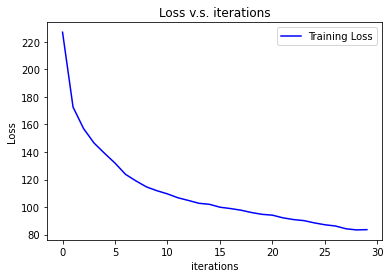

In [61]:
_ = plt.plot(hist1.history["loss"],'b',label="Training Loss")

_ = plt.xlabel('iterations')
_ = plt.ylabel('Loss')
_ = plt.legend(loc="best")

_ = plt.title('Loss v.s. iterations')

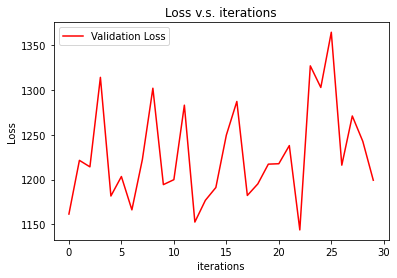

In [60]:

_ = plt.plot(hist1.history["val_loss"],'r',label="Validation Loss")
_ = plt.xlabel('iterations')
_ = plt.ylabel('Loss')
_ = plt.legend(loc="best")

_ = plt.title('Loss v.s. iterations')

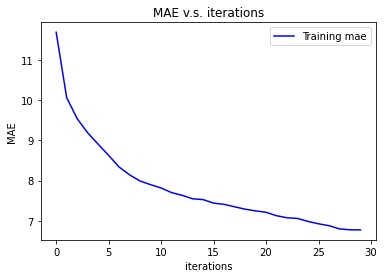

In [65]:
_ = plt.plot(hist1.history["mae"],'b',label="Training mae")

_ = plt.xlabel('iterations')
_ = plt.ylabel('MAE')
_ = plt.legend(loc="best")

_ = plt.title('MAE v.s. iterations')

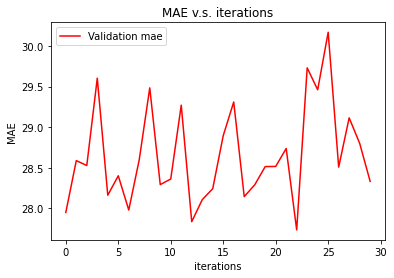

In [64]:
_ = plt.plot(hist1.history["val_mae"],'r',label="Validation mae")
_ = plt.xlabel('iterations')
_ = plt.ylabel('MAE')
_ = plt.legend(loc="best")

_ = plt.title('MAE v.s. iterations')

### 5 Worst predicted samples

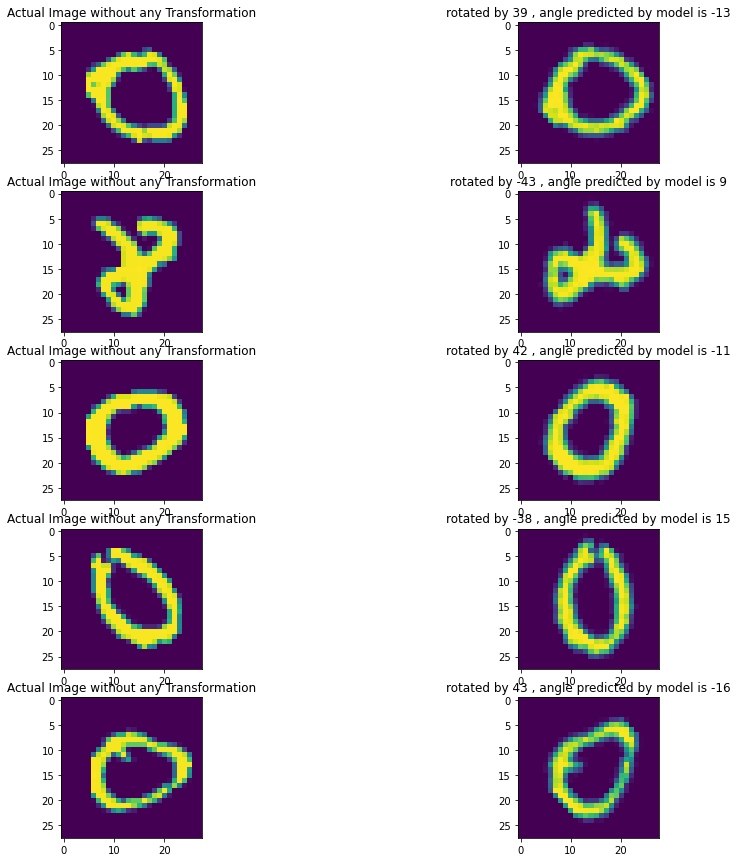

In [23]:
worst_predicted_numbers=model_perf(x_test,y_test,predictions_test,angle_test).sort_values("abs_error").tail().index
s=5
arr,axi=plt.subplots(5,2)
arr.set_figheight(15)
arr.set_figwidth(15)
for i in range(5):
    axi[i,0].imshow(x_test[worst_predicted_numbers[i],:,:])
    axi[i,1].imshow(rx_test[worst_predicted_numbers[i],:,:])
    axi[i,1].set_title('rotated by '+str(angle_test[worst_predicted_numbers[i]])+' , angle predicted by model is '+str(int(predictions_test[worst_predicted_numbers[i]])))
    axi[i,0].set_title("Actual Image without any Transformation")

**Reasoning for worst 5 prediction**<br>
Among 5 worst predicted samples there are four 0's and one 8, It is difficult for the model to predict these images because "0"(zero) is 360 degrees symmetry so how much ever we rotate the zero it remains same, which makes it diffult to determine its actual transformation. and even number 8 has the symmetry property and number 8 also has two circles and there are other numbers which have circles(number 0,6,9) so when rotated it coincides with other numbers(like 0,6,9) and also the number 8 here is not properly written